<a href="https://colab.research.google.com/github/jyotisman-ds/TensorFlow_projects/blob/main/Beans_fullCalssifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import tensorflow as tf
import numpy as np

## defining augmentations

#Flip Augmentation : returns a flipped version of the input image
def flip(x: tf.Tensor) -> tf.Tensor:
    
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)

    return x

#Rotation augmentation : returns a roatated version of the input image
def rotate(x: tf.Tensor) -> tf.Tensor:

    return tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

# #Zoom augmentation : returns a zoomed version of the input image
# def zoom(x: tf.Tensor) -> tf.Tensor:

#     # Generate 20 crop settings, ranging from a 1% to 20% crop.
#     scales = list(np.arange(0.8, 1.0, 0.01))
#     boxes = np.zeros((len(scales), 4))

#     for i, scale in enumerate(scales):
#         x1 = y1 = 0.5 - (0.5 * scale)
#         x2 = y2 = 0.5 + (0.5 * scale)
#         boxes[i] = [x1, y1, x2, y2]

#     def random_crop(img):
#         # Create different crops for an image
#         crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(150,150))
#         # Return a random crop
#         return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]


#     #choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

#     # Only apply cropping 50% of the time

#     # tf.cond(choice < 0.5, lambda: tf.cast(x, tf.float32), lambda: random_crop(x))

#     return random_crop(x)

# def zoom(x: tf.Tensor) -> tf.Tensor:
#   return tf.keras.preprocessing.image.random_zoom(x, zoom_range=(np.random.uniform(0.6,0.9),np.random.uniform(0.6,0.9)),row_axis = 0, col_axis = 1,channel_axis = 2)

def zoom(x: tf.Tensor) -> tf.Tensor:
  return tf.numpy_function(lambda img: tf.keras.preprocessing.image.random_zoom(
      img, zoom_range=(np.random.uniform(0.5,0.8),np.random.uniform(0.5,0.8)), 
      row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest',), [x], tf.float32)

In [27]:
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt

beans, info = tfds.load('beans', with_info=True, as_supervised=True)

train_ds = beans['train']
valid_ds = beans['validation']
test_ds = beans['test']

num_classes = info.features['label'].num_classes


def resize_normalize_img(image, label):
  """resizes and normalizes images: `uint8` -> `float32`."""
  image = tf.image.resize(image, [150, 150])
  return tf.cast(image, tf.float32) / 255., label


train_ds = train_ds.map(resize_normalize_img)
valid_ds = valid_ds.map(resize_normalize_img)
test_ds = test_ds.map(resize_normalize_img)


def flip_img(image, label):
  """applies the flip transformation"""
  if tf.random.uniform([], 0, 1) > 0.2:
    return flip(image), label
  else:
    return image, label

def rotate_img(image, label):
  """applies the rotation transformation"""
  if tf.random.uniform([], 0, 1) > 0.2:
    return rotate(image), label
  else:
    return image, label

def zoom_img(image, label):
  """applies the zoom transformation"""
  if tf.random.uniform([], 0, 1) > 0.2:
    return zoom(image), label
  else:
    return image, label

augmentations = [flip_img, zoom_img, rotate_img]

for f in augmentations:
    train_ds = train_ds.map(f, num_parallel_calls=tf.data.AUTOTUNE)

def clip_dataset(img, label):
    return tf.clip_by_value(img, 0, 1), label

train_ds = train_ds.map(clip_dataset)

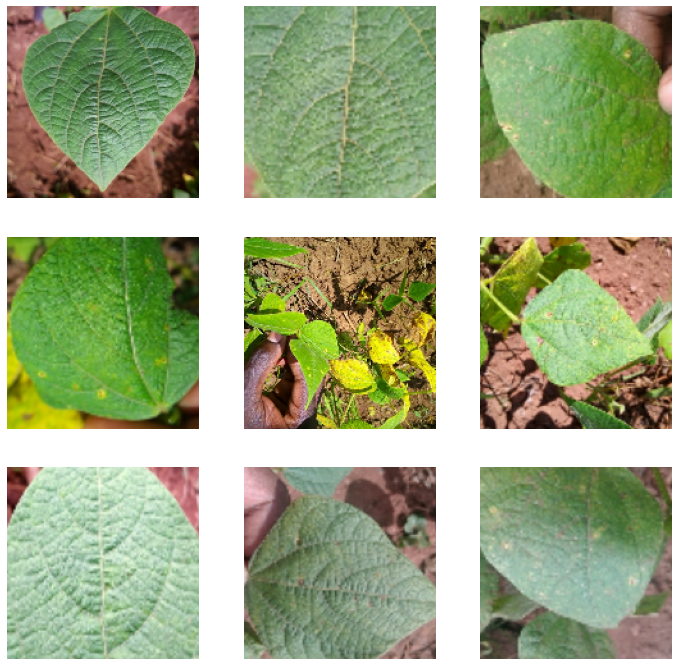

In [28]:
ncols = 3
nrows = 3
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
count = 0
for image, _ in train_ds.take(100).repeat(5).shuffle(400).as_numpy_iterator():
     if count >= 9:
         break
     plt.subplot(nrows,ncols,count+1).axis('Off')
     plt.imshow(image)
     count+=1
plt.show()

In [29]:
# train_ds = train_ds.map(resize_normalize_img)
# valid_ds = valid_ds.map(resize_normalize_img)
# test_ds = test_ds.map(resize_normalize_img)

# Lets use callbacks to cancel training when a desired accuracy is reached
class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if(logs.get('val_accuracy')>0.90):
      print('\nReached 90% val_accuracy, so cancelling training')
      self.model.stop_training = True

callbacks = myCallback()

train_ds = train_ds.repeat(5) #including augmented images

train_ds = train_ds.shuffle(100000)
train_ds = train_ds.batch(256).prefetch(tf.data.AUTOTUNE)

model = keras.Sequential([keras.layers.Conv2D(16, (3,3), activation = 'relu', input_shape=(150,150,3)),
                          keras.layers.MaxPooling2D(2,2),
                          keras.layers.Conv2D(32,(3,3), activation = 'relu'),
                          keras.layers.MaxPooling2D(2,2),
                          keras.layers.Dropout(0.3),
                          keras.layers.Flatten(),
                          keras.layers.Dense(128, activation='relu'),
                          keras.layers.Dense(num_classes, activation='softmax')
                          ])

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()


# history = model.fit(train_ds,
#                     batch_size = 32,
#                     epochs = 50,
#                     validation_data = valid_ds,
#                     callbacks = [callbacks]
#                     )

history = model.fit(train_ds,
                    epochs = 100,
                    validation_data = valid_ds.batch(256),
                    callbacks = [callbacks]
                    )

model.evaluate(test_ds.batch(info.splits['test'].num_examples))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 36, 36, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               5

[0.562232494354248, 0.8671875]

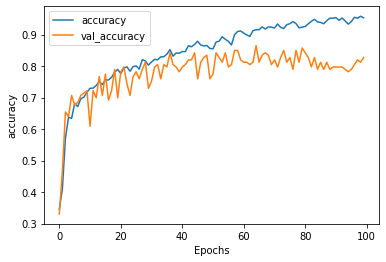

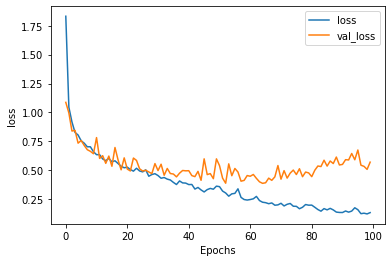

In [30]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [6]:
!pip install tensorflowjs

     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 112kB 22.9MB/s 
  Found existing installation: tensorflow-hub 0.11.0
    Uninstalling tensorflow-hub-0.11.0:
      Successfully uninstalled tensorflow-hub-0.11.0


In [7]:
import time
saved_model_path = "./{}.h5".format(int(time.time()))

model.save(saved_model_path)

In [8]:
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

2021-01-11 23:56:10.968860: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
